In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN
from data import fmap
import functools
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import dask

/users/nperraud/default/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [3]:
ns = 32
try_resume = True
Mpch = 350
shift = 3
c = 20000
res = 256
def forward(x):
    return fmap.stat_forward(x, shift=shift, c=c)
def backward(x):
    return fmap.stat_backward(x, shift=shift, c=c)
def non_lin(x):
#     return tf.nn.relu(x)
    return x

# Data handling

Load the data

In [4]:
dataset = data.load.load_dataset(spix=ns, resolution=res,Mpch=Mpch, forward_map=forward)

images shape =  (10, 256, 256, 256)


In [5]:
X = dataset.get_all_data().flatten()

In [6]:
# assert(np.sum(np.abs(forward(backward(X))-X))< 5)
# For debugging
np.sum(np.abs(forward(backward(X))-X))
# forward(backward(X))-X
# x = np.arange(1e4)
# plt.plot(x, backward(forward(x))-x)

0.0

min: 0.0
max: 5.1900529861450195


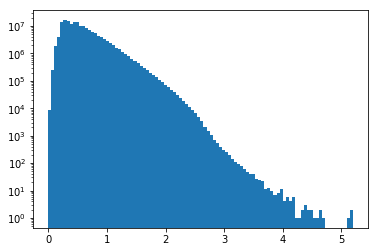

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

Let us plot 16 images

In [8]:
del X

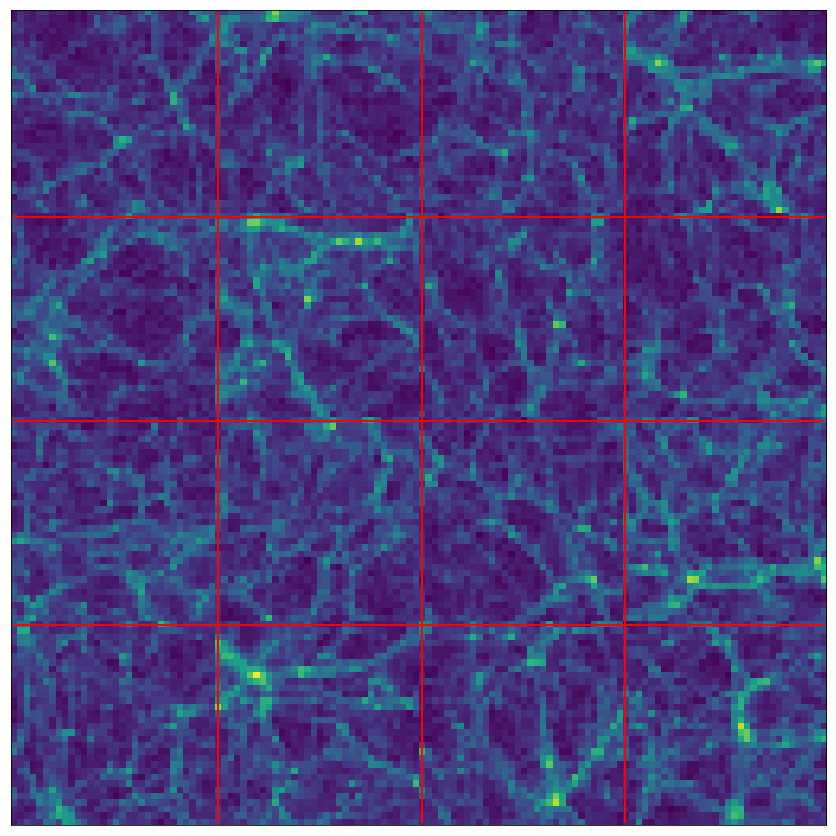

In [9]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [10]:
# time_str = 'stat_c_{}_shift_{}_laplacian_Mpch_{}_res_{}_no_non_lin'.format(c, shift, Mpch, res)
time_str = 'test_to_erease'
global_path = '/scratch/snx3000/nperraud/saved_result'

name = 'WGAN{}'.format(ns)

## Parameters

In [11]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 1]
params_discriminator['nfilter'] = [16, 64, 256, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn]
params_discriminator['cdf'] = 256
# params_discriminator['moment'] = [5,5]
params_discriminator['full'] = [64]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [1, 1, 2, 1, 1]
params_generator['latent_dim'] = 16*16*32
params_generator['nfilter'] = [32, 64, 256, 32, 1]
params_generator['shape'] = [[5, 5], [5, 5],[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['full'] = []
params_generator['summary'] = True
params_generator['non_lin'] = None

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'adam' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'adam' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.5
params_optimization['beta2'] = 0.99
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 5


params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward
params_cosmology['Nstats'] = 5000


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'laplacian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = os.path.join(global_path, params['name'] + '_' + time_str +'_summary/')
params['save_dir'] = os.path.join(global_path,params['name'] + '_' + time_str + '_checkpoints/')



In [12]:
resume, params = utils.test_resume(try_resume, params)
# params['optimization']['disc_learning_rate'] = 3e-6
# params['optimization']['gen_learning_rate'] = 3e-6
# params['optimization']['epoch'] = 10


No resume, the training will start from the beginning!


## Build the model

In [13]:
wgan = CosmoGAN(params, WGanModel)

Generator 
--------------------------------------------------
     The input is of size (?, 8192)
     Reshape to (?, 16, 16, 32)
     0 Deconv layer with 32 channels
         Size of the variables: (?, 16, 16, 32)
     1 Deconv layer with 64 channels
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 256 channels
         Size of the variables: (?, 32, 32, 256)
     3 Deconv layer with 32 channels
         Size of the variables: (?, 32, 32, 32)
     4 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
     The output is of size (?, 32, 32, 1)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input is of size (?, 32, 32, 1)
    Cdf layer: 256
         Size of the cdf variables: (?, 512)
     CDF Full layer with 512 outputs
         Size of the CDF variables: (?, 512)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv lay

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [ ]:
wgan.train(dataset, resume=resume)

Erase recursively directory: /scratch/snx3000/nperraud/saved_result/WGAN32_test_to_erease_checkpoints/
Epoch: [ 0] [  99/10240] Counter:100	( 0.4 min	70.701 examples/sec	0.23 sec/batch)	L_Disc:-1.54994464	L_Gen:-2.74755406
Epoch: [ 0] [ 199/10240] Counter:200	( 0.6 min	107.469 examples/sec	0.15 sec/batch)	L_Disc:-0.87622249	L_Gen:-8.25867367
Epoch: [ 0] [ 299/10240] Counter:300	( 0.9 min	107.435 examples/sec	0.15 sec/batch)	L_Disc:-0.55154818	L_Gen:-11.53445339
Epoch: [ 0] [ 399/10240] Counter:400	( 1.1 min	107.488 examples/sec	0.15 sec/batch)	L_Disc:-0.61596549	L_Gen:-12.00353336
Epoch: [ 0] [ 499/10240] Counter:500	( 1.4 min	107.559 examples/sec	0.15 sec/batch)	L_Disc:-0.61303699	L_Gen:-9.84157944
 [*] [Fake, Real] Min [0.000, 1.217],	Median [16.013,16.499],	Mean [2.734E+01,6.393E+01],	Max [7.142E+02,6.961E+03],	Var [3.332E+03,1.982E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.250, 0.241, 1.440]	CrossPS:[1.074, 3.302, -1.558]
 [*] New PSD Low achieved 301813.427809 (was 10000000000.0

In [ ]:
gen_sample, gen_sample_raw = wgan.generate(N=5000, checkpoint=None)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

In [ ]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [ ]:
raw_images = backward(dataset.get_samples(dataset.N))

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

In [ ]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)